In [ ]:
### This notebook shows the design of the proposed model SDBNetV2. We also provide the model's weight
### on KITTI dataset and a sample test image of KITTI test set. Using the weight and following code,
### you can generate the colored prediction. You may need to change the path of the weight and input image.

In [12]:
"""
Implementation of SDBNetV2 using Tensorflow 2.1 and TF.Keras

Official paper is under review.
Author: Tanmay Singha; Duc-Son Pham; AneeshKrishna
GitHub: https://github.com/tanmaysingha/SDBNetV2

# -*- coding: utf-8 -*-
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.
"""

from functools import reduce
import tensorflow as tf
from tensorflow import keras
import numpy as np
import tensorflow.keras.backend as K


#### Custom function for conv2d: conv_block
def conv_block(inputs, conv_type, kernel, kernel_size, strides, padding='same', relu=True, use_bias=True):

      if(conv_type == 'ds'):
        x = tf.keras.layers.SeparableConv2D(kernel, kernel_size, padding=padding, strides = strides)(inputs)
      else:
        x = tf.keras.layers.Conv2D(kernel, kernel_size, padding=padding, strides = strides)(inputs)

      x = tf.keras.layers.BatchNormalization()(x)

      if (relu):

        x = tf.keras.layers.Activation(lambda x: tf.nn.swish(x))(x)

      return x

#Shallow_block
def shallow_block(inputs, kernel, kernel_size, strides):

      x = conv_block(inputs, 'ds', kernel, kernel_size, strides = (2, 2))
      x = conv_block(x, 'ds', kernel, (3, 3), strides = (1, 1))

      y = conv_block(inputs, 'conv', kernel, (3, 3), strides = (strides, strides))

      Shallow_output = tf.keras.layers.add([x, y])

      return Shallow_output

def SE_block(inputs, filters, expand_filters, kernel, strides=(1, 1), r=False):

    x = conv_block(inputs, 'conv', expand_filters, (1, 1), strides=(1, 1))

    x = tf.keras.layers.DepthwiseConv2D(kernel, strides=strides, dilation_rate=(1,1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)

    x = conv_block(x, 'conv', filters, (1, 1), strides=(1, 1), padding='same', relu=False)

    if r:
        x = tf.keras.layers.add([x, inputs])
    return x

def _res_bottleneck(inputs, filters, kernel, t, strides, r=False):

    tchannel = filters
    tchannel1 = tchannel
    tchannel2 = tchannel * 2
    tchannel3 = tchannel * 3
    tchannel4 = tchannel * 4

    if r:
        x1 = SE_block(inputs, tchannel, tchannel2, kernel, strides=(1,1))
        x2 = SE_block(x1, tchannel, tchannel3, kernel, strides=(1,1))
        x2 = tf.keras.layers.UpSampling2D(size=(1, 1), interpolation='bilinear')(x2)
        x4 = SE_block(x2, tchannel, tchannel4, kernel, strides=(1, 1))

    else:
        x1 = SE_block(inputs, tchannel, tchannel2, kernel, strides=(strides,strides))
        x2 = SE_block(x1, tchannel, tchannel3, kernel, strides=(strides,strides))
        x2 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x2)
        x4 = SE_block(x2, tchannel, tchannel4, kernel, strides=(1, 1))

    STDC_block = tf.keras.layers.add([x1, x4])

    if r:
        STDC_block = tf.keras.layers.add([STDC_block, inputs])
    return STDC_block


"""#### Bottleneck custom method"""

def bottleneck_block(inputs, filters, kernel, t, strides, n):
      x = _res_bottleneck(inputs, filters, kernel, t, strides)

      for i in range(1, n):
        x = _res_bottleneck(x, filters, kernel, t, 1, True)

      return x

def DenseFR_block(input_tensor):
      shape = list(input_tensor.shape)
      h = shape[1]
      w = shape[2]
      c = shape[3]
      ch = int(shape[3] // 4)

      # 1x1 Convolution
      conv1x1 = tf.keras.layers.Conv2D(ch, 1, strides=1, padding='same', use_bias=False)(input_tensor)
      norm1x1 = tf.keras.layers.BatchNormalization()(conv1x1)
      relu1x1 = tf.keras.activations.relu(norm1x1)

      # Separable Convolution
      conv3x3_d6 = tf.keras.layers.SeparableConv2D(ch, 3, strides=1, padding='same', dilation_rate=(6, 6))(relu1x1)
      norm3x3_d6 = tf.keras.layers.BatchNormalization()(conv3x3_d6)
      relu3x3_d6 = tf.keras.activations.relu(norm3x3_d6)

      # Separable Convolution
      conv3x3_d12 = tf.keras.layers.SeparableConv2D(ch, 3, strides=1, padding='same', dilation_rate=(12, 12))(relu3x3_d6)
      norm3x3_d12 = tf.keras.layers.BatchNormalization()(conv3x3_d12)
      relu3x3_d12 = tf.keras.activations.relu(norm3x3_d12)

      # Separable Convolution
      conv3x3_d18 = tf.keras.layers.SeparableConv2D(ch, 3, strides=1, padding='same', dilation_rate=(18, 18))(relu3x3_d12)
      norm3x3_d18 = tf.keras.layers.BatchNormalization()(conv3x3_d18)
      relu3x3_d18 = tf.keras.activations.relu(norm3x3_d18)

      concat = tf.keras.layers.Concatenate()([relu1x1, relu3x3_d6, relu3x3_d12, relu3x3_d18])

      concat = tf.keras.layers.add([concat, input_tensor])
      concat = tf.keras.activations.relu(concat)

      return concat

def SA_block(f1, f2, f3, kernel=256):
    f1 = tf.keras.layers.Conv2D(kernel, 1, padding='same', strides = 1)(f1)
    f1 = tf.keras.activations.relu(f1)

    f2 = tf.keras.layers.Conv2D(kernel, 1, padding='same', strides = 1)(f2)
    f2 = tf.keras.activations.relu(f2)

    f3 = tf.keras.layers.Conv2D(kernel, 1, padding='same', strides = 1)(f3)
    f3 = tf.keras.activations.relu(f3)

    SA = tf.keras.layers.Concatenate()([f1, f2, f3])
    SA = conv_block(SA, 'ds', kernel, (1, 1), strides = (1, 1))
    atten = tf.nn.avg_pool2d(SA, kernel, 1, 'SAME')

    atten = tf.keras.layers.Conv2D(kernel, 1, padding='same', strides = 1)(atten)
    atten = tf.keras.activations.sigmoid(atten)
    SA_atten = tf.keras.layers.Multiply()([atten, SA])
    SA_out = tf.keras.layers.add([atten, SA])

    return SA_out


def model(num_classes=19, input_size=(1024, 2048, 3)):

      # Input Layer
      input_layer = tf.keras.layers.Input(shape=input_size, name = 'input_layer')

      ## Step 1: Learning to DownSample
      input1 = conv_block(input_layer, 'conv', 32, (7, 7), strides = (2, 2))

      input2 = conv_block(input1, 'ds', 48, (5, 5), strides = (2, 2))

      #shallow branch
      S3 = shallow_block(input2, 64, (5, 5), strides=2)
      S4 = shallow_block(S3, 96, (5, 5), strides=2)
      S5 = shallow_block(S4, 128, (5, 5), strides=2)


      #deep branch
      D3 = bottleneck_block(input2, 64, (3, 3), t=1, strides=2, n=2)
      D3 = tf.keras.layers.add([D3, S3])

      D4 = bottleneck_block(D3, 96, (3, 3), t=1, strides=2, n=2)
      D4 = tf.keras.layers.add([D4, S4])

      D5 = bottleneck_block(D4, 128, (3, 3), t=1, strides=2, n=2)
      D5 = tf.keras.layers.add([D5, S5])

      F5 = D5
      F5_in = tf.keras.layers.Conv2D(64, 1, 1, padding='same', activation=None)(F5)
      F5_in = tf.keras.layers.BatchNormalization()(F5_in)
      F5_in = DenseFR_block(F5_in)

      F4 = D4
      F4_in = tf.keras.layers.Conv2D(64, 1, 1, padding='same', activation=None,)(F4)
      F4_in = tf.keras.layers.BatchNormalization()(F4_in)
      F4_in = DenseFR_block(F4_in)

      F3 = D3
      F3_in = tf.keras.layers.Conv2D(64, 1, 1, padding='same', activation=None,)(F3)
      F3_in = tf.keras.layers.BatchNormalization()(F3_in)
      F3_in = DenseFR_block(F3_in)

      SF4 = S4
      SF4_in = tf.keras.layers.Conv2D(64, 1, 1, padding='same', activation=None,)(SF4)
      SF4_in = tf.keras.layers.BatchNormalization()(SF4_in)

      SF3 = S3
      SF3_in = tf.keras.layers.Conv2D(64, 1, 1, padding='same', activation=None,)(SF3)
      SF3_in = tf.keras.layers.BatchNormalization()(SF3_in)

      F5_U = tf.keras.layers.UpSampling2D()(F5_in)
      ff4 = SA_block(F5_U, F4_in, SF4_in, kernel=64)

      F4_U = tf.keras.layers.UpSampling2D()(ff4)
      ff3 = SA_block(F4_U, F3_in, SF3_in, kernel=64)


      ## Step 4: Classifier

      classifier = tf.keras.layers.SeparableConv2D(64, (3, 3), padding='same', strides = (1, 1), name = 'DSConv1_classifier')(ff3)
      classifier = tf.keras.layers.BatchNormalization()(classifier)
      classifier = tf.keras.layers.Activation(lambda x: tf.nn.swish(x))(classifier)

      classifier = tf.keras.layers.SeparableConv2D(48, (3, 3), padding='same', strides = (1, 1), name = 'DSConv2_classifier')(classifier)
      classifier = tf.keras.layers.BatchNormalization()(classifier)
      classifier = tf.keras.layers.Activation(lambda x: tf.nn.swish(x))(classifier)

      classifier = tf.keras.layers.Conv2D(num_classes, 1, 1, padding='same', activation=None,
                                          kernel_regularizer=keras.regularizers.l2(0.00004),
                                          bias_regularizer=keras.regularizers.l2(0.00004))(classifier)

      classifier = tf.keras.layers.Dropout(0.35)(classifier)
      classifier = tf.dtypes.cast(classifier, tf.float32)
      classifier = tf.keras.activations.softmax(classifier)

      classifier = tf.keras.layers.UpSampling2D(size=(8, 8), interpolation='bilinear')(classifier)

      SDBNetV2 = tf.keras.Model(inputs = input_layer , outputs = classifier, name = 'SDBNetV2')

      return SDBNetV2

In [13]:
SDBNetV2 = model(num_classes=19, input_size=(384, 1280, 3))
SDBNetV2.summary()

Model: "SDBNetV2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 384, 1280,   0           []                               
                                3)]                                                               
                                                                                                  
 conv2d_171 (Conv2D)            (None, 192, 640, 32  4736        ['input_layer[0][0]']            
                                )                                                                 
                                                                                                  
 batch_normalization_258 (Batch  (None, 192, 640, 32  128        ['conv2d_171[0][0]']             
 Normalization)                 )                                                          

In [6]:
!pip install cityscapesscripts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 473.3/473.3 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.8 MB/s eta 0:00:00
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26305 sha256=4ee75b0f15b903a1159fa368922fcc3aecfaedce4995b0929be163e78aebd5a3
  Stored in directory: /root/.cache/pip/wheels/7c/d0/9e/1f26ebb66d9e1732e4098bc5a6c2d91f6c9a529838f0284890
Successfully built typing


In [9]:
from tensorflow import keras
import tensorflow as tf
import cityscapesscripts.helpers.labels as labels
import numpy as np
import PIL
import argparse
import sys
import os
import glob
import matplotlib.image as Image

"""gpus = tf.config.list_physical_devices('GPU')
# Set Memory Growth to alleviate memory issues
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    tf.config.set_visible_devices(gpus, 'GPU')"""

#----------IMPORT MODELS AND UTILITIES----------#


KITTI_LABELS = [
    label for label in labels.labels if -1 < label.trainId < 255]

# Get all the colors
KITTI_COLORS = [label.color for label in KITTI_LABELS]
# Get the IDS
KITTI_IDS = [7,8,11,12,13,17,19,20,21,22,23,24,25,26,27,28,31,32,33]

KITTI_TRAINIDS = [label.trainId for label in KITTI_LABELS]

CLASSES = 19

KITTI_ROOT = "/content"
file = glob.glob(os.path.join(KITTI_ROOT+"/KITTI_test_sample.png"))

# Load the weights
SDBNetV2.load_weights("/content/KITTI_weights.hdf5")

total = 0
elapsed_times = []
for image_path in file:
    image_string = tf.io.read_file(image_path)


    #predicting LabelID val/test images.While running predict.py, please give the right path for LabelID images.
    image = tf.image.decode_png(image_string, channels=3)
    w = image.shape[0]
    h = image.shape[1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (384, 1280), method='nearest')
    image = tf.expand_dims(image, 0)

    prediction = SDBNetV2.predict(image)
    prediction = tf.reshape(tf.argmax(prediction, axis=-1),(384, 1280, 1))
    prediction = np.matmul(tf.one_hot(prediction, CLASSES), KITTI_TRAINIDS)
    prediction = tf.image.resize(prediction,(w, h), method='nearest')

    semantic_map = []
    for id in KITTI_TRAINIDS:
      class_map = tf.reduce_all(tf.equal(prediction, id), axis=-1)
      semantic_map.append(class_map)
    # Save the Image
    semantic_map = tf.stack(semantic_map, axis=-1)
    semantic_map = tf.cast(semantic_map, tf.float32)
    prediction = semantic_map.numpy()
    prediction = np.matmul(prediction, KITTI_COLORS)
    Image.imsave(KITTI_ROOT+'/prediction.png',prediction.astype(np.uint8), dpi=300)


1/1 [==============================] - 4s 4s/step


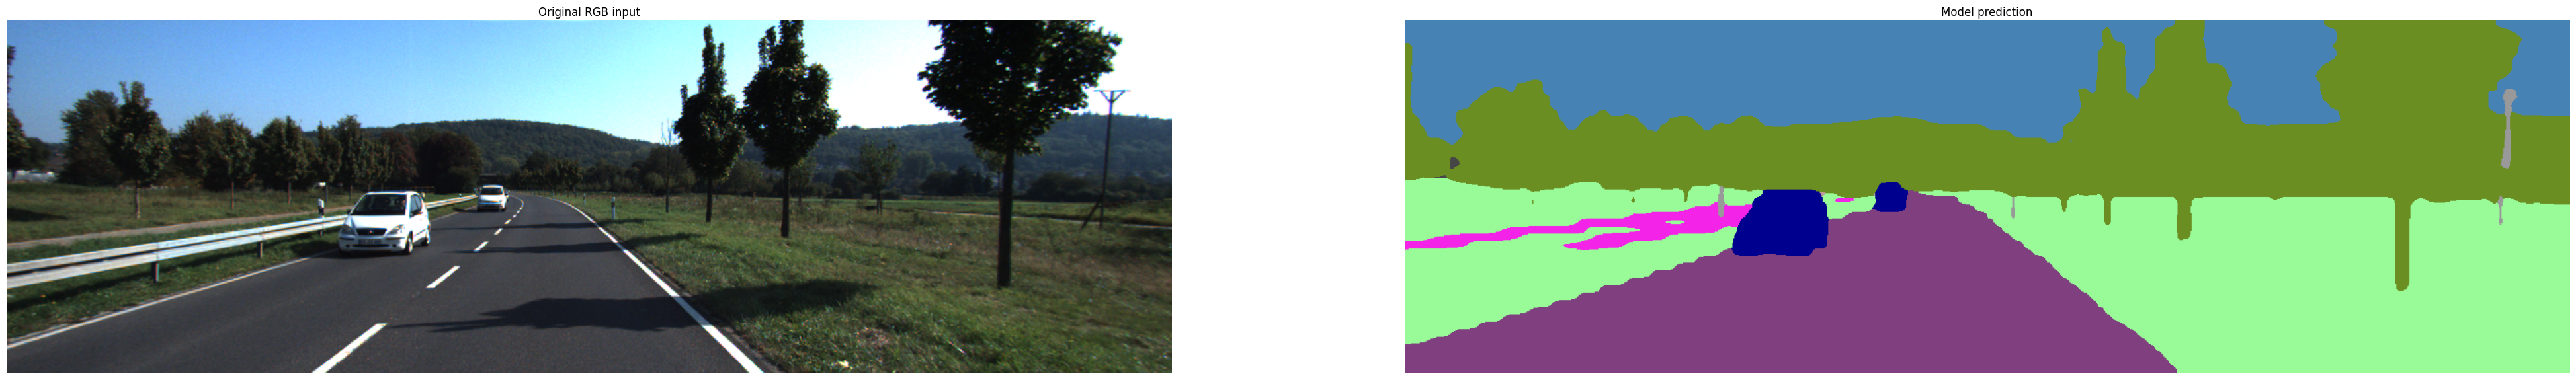

In [11]:
import matplotlib.pyplot as plt

image_file = '/content/KITTI_test_sample.png'
RGB_string =  tf.io.read_file(image_file)
RGB_image = tf.image.decode_png(RGB_string, channels=3)
#RGB_image = tf.image.resize(RGB_image,(target_size[0], target_size[1]), method='nearest')

image_file = '/content/prediction.png'
Pred_string =  tf.io.read_file(image_file)
Pred_image = tf.image.decode_png(Pred_string, channels=3)
#RGB_image = tf.image.resize(RGB_image,(target_size[0], target_size[1]), method='nearest')

plt.rcParams['figure.figsize'] = [50, 20]
plt.subplots(1,2)

plt.subplot(1,2,1)
plt.title('Original RGB input')
plt.axis('off')
plt.imshow(RGB_image)

plt.subplot(1,2,2)
plt.title('Model prediction')
plt.axis('off')
plt.imshow(Pred_image)